In [164]:
from sklearn.datasets import fetch_openml #importando o open ML
import pandas as pd                       
import matplotlib.pyplot as plt           
import seaborn as sns                    
import numpy as np        

from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, cohen_kappa_score                      
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV # método para seleção dos melhores Ks (#Basicamente a busca por força bruta)
from sklearn.metrics import make_scorer, accuracy_score, f1_score # métricas de validação

In [165]:
df = pd.read_csv('./dados/HR_abandono.csv', sep=';')
df.head()

,id,satisfaction_level,last_evaluation,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,salary,num_project,depto
0,1,"0,38","0,53",157,3,0,1,0,low,2,sales
1,2,"0,8","0,86",262,6,0,1,0,medium,5,sales
2,3,"0,11","0,88",272,4,0,1,0,medium,6,sales
3,4,"0,72","0,87",223,5,0,1,0,low,5,sales
4,5,"0,37","0,52",159,3,0,1,0,low,2,sales


In [166]:
df.shape

(14999, 11)

### Limpeza e análise exploratória dos dados

In [167]:
df.isnull().sum()

id                       0
satisfaction_level       0
last_evaluation          0
average_montly_hours     0
time_spend_company       0
Work_accident            0
left                     0
promotion_last_5years    0
salary                   0
num_project              0
depto                    0
dtype: int64

In [168]:
df.describe()

,id,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,num_project
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,7500.000000,201.083672,3.407027,0.144610,0.238083,0.021268,3.785986
std,4329.982679,50.182121,1.176120,0.351719,0.425924,0.144281,1.194539
min,1.000000,96.000000,2.000000,0.000000,0.000000,0.000000,2.000000
25%,3750.500000,156.000000,3.000000,0.000000,0.000000,0.000000,3.000000
50%,7500.000000,200.000000,3.000000,0.000000,0.000000,0.000000,4.000000
75%,11249.500000,245.000000,4.000000,0.000000,0.000000,0.000000,5.000000
max,14999.000000,810.000000,6.000000,1.000000,1.000000,1.000000,6.000000


#### Observação: Nesta base de dados, as colunas 'satisfaction_level' e 'last_evaluation' possuem virgula separando as casas que indica que estão no formato de string, portando a conversão para 'float'

In [169]:
df['satisfaction_level'] = df['satisfaction_level'].str.replace(',', '.', regex=True)
df['last_evaluation'] = df['last_evaluation'].str.replace(',', '.', regex=True)

In [170]:
df['satisfaction_level'] = df['satisfaction_level'].astype('float64')
df['last_evaluation'] = df['last_evaluation'].astype('float64')

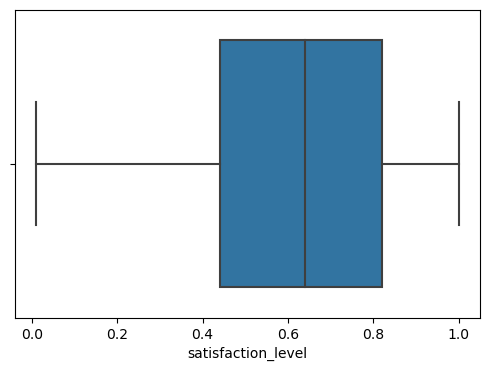

In [171]:
fig = plt.figure(figsize=(6,4))

sns.boxplot(data=df, x='satisfaction_level')

plt.show()

In [172]:
df[df['average_montly_hours'] > 400]

,id,satisfaction_level,last_evaluation,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,salary,num_project,depto
14972,14973,0.11,0.97,810,4,0,1,0,medium,6,accounting


### Eliminando o outlier acima pois ninguém trabalha 28 horas por dia

In [173]:
df.drop(axis=0, index=df[df['average_montly_hours'] > 400].index, inplace=True)

In [174]:
selected_cols = df.columns[~df.columns.isin(['id','depto','salary'])]

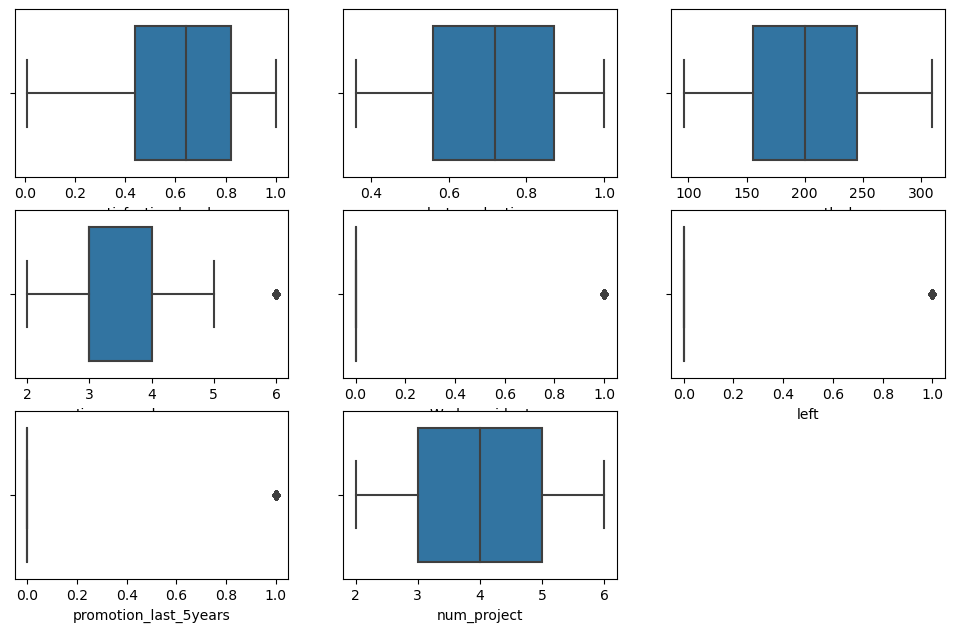

In [175]:
plt.figure(figsize=(12,10))

for i, cols in enumerate(selected_cols):
    plt.subplot(4,3,i+1)
    sns.boxplot(data=df, x=cols)
    
plt.show()

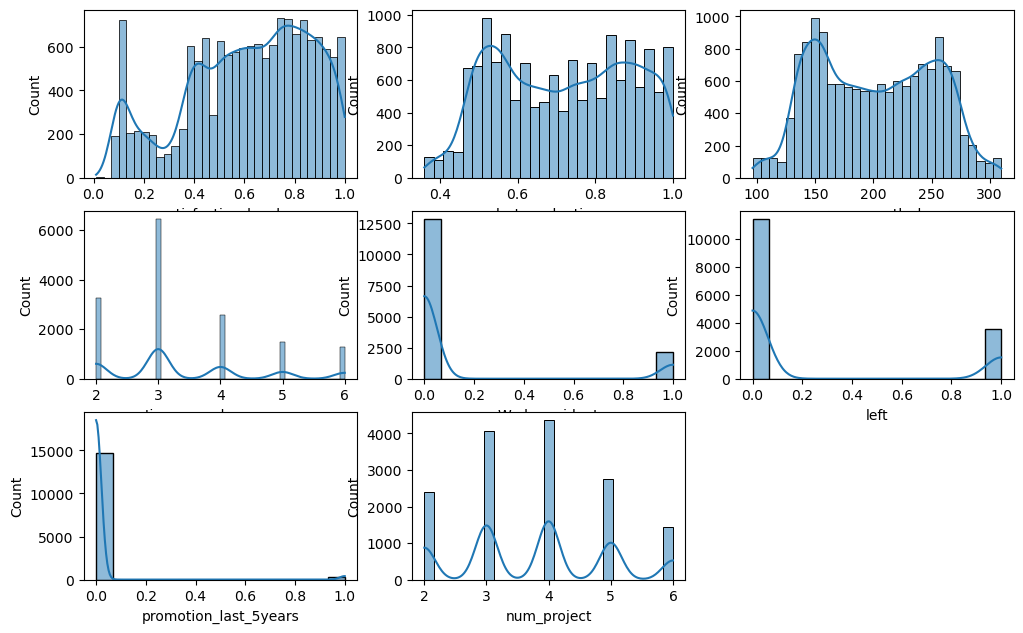

In [176]:
plt.figure(figsize=(12,10))

for i, cols in enumerate(selected_cols):
    plt.subplot(4,3,i+1)
    sns.histplot(data=df, x=cols, kde=True)
      
plt.show()

### Utilizando o LabelEncoder para observar as correlações (numeric_only)

In [189]:
label_encoder = LabelEncoder()

In [190]:
df['depto']=label_encoder.fit_transform(df['depto'])
df['salary']=label_encoder.fit_transform(df['salary'])


In [191]:
x=df[selected_cols]
y=df['salary']

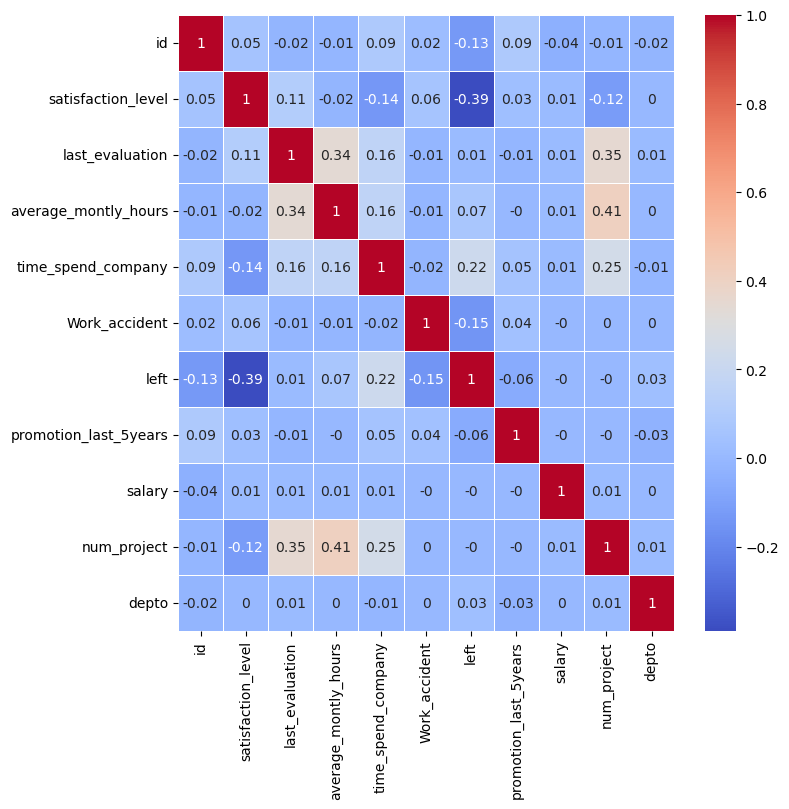

In [192]:
correlation_matrix=df.corr().round(2)
fig, ax = plt.subplots(figsize=(8,8))    

sns.heatmap(data=correlation_matrix, cmap='coolwarm', annot=True, linewidths=0.5, ax=ax )

plt.show()

In [193]:
selected_cols = df.corr()['depto'].sort_values(ascending=False).index[1:7]
selected_cols

Index(['left', 'num_project', 'last_evaluation', 'average_montly_hours',
       'Work_accident', 'satisfaction_level'],
      dtype='object')

In [194]:
x=df[selected_cols]
y=df['depto']

In [195]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=7)

### Feature Scaling

In [156]:
def min_max_scaler(x_train, x_test):
    scaler = MinMaxScaler()
    scaler.fit(x_train)
    x_train_scaled = scaler.transform(x_train)
    x_test_scaled = scaler.transform(x_test)
    return [x_train_scaled, x_test_scaled]

def standard_scaler(x_train, x_test):
    scaler = StandardScaler()
    scaler.fit(x_train)
    x_train_scaled = scaler.transform(x_train)
    x_test_scaled = scaler.transform(x_test)
    return [x_train_scaled, x_test_scaled]

def smote(x_train, y_train):
    oversample = SMOTE()
    return oversample.fit_resample(x_train, y_train)

# x_train_scaled, x_test_scaled = min_max_scaler(x_train, x_test)

x_train_scaled, x_test_scaled = standard_scaler(x_train_os, x_test)

x_train_os, y_train_os = smote(x_train, y_train)
# y_train_os.value_counts()

### KNeighborsClassifier

In [25]:
# Buscar os melhores parâmetros
# Vamos usar uma técnica chamada Gridsearch que é basicamente a busca por força bruta
# Iremos utilizar a técnica de validação cruzada de 5 folds (divisões) em cima do conjunto de treinamento
# Como métrica de melhor desempenho usaremos a acurácia, isto é, estamos buscando os hiperparâmetros que maximizam a acurácia

# Parâmetros testados
param_grid = {'n_neighbors':[1,14], #total de vizinhos
              'weights': ['uniform', 'distance'], #Função de peso usada na previsão
              'metric':['cosine', 'euclidean', 'manhattan'] #métrica para cálculo da distância
             }

# Métrica de desempenho = melhor acurácia
gs_metric = make_scorer(accuracy_score, greater_is_better=True)

grid = GridSearchCV(KNeighborsClassifier(), 
                    param_grid=param_grid,
                    scoring=gs_metric,
                    cv=5, n_jobs=4, verbose=3) #cv = gerador de validação cruzada / n_jobs = determina a quantidade de jobs processados

grid.fit(x_train_os, y_train_os) 
# grid.fit(x_train, y_train)
knn_params = grid.best_params_
print('KNN', knn_params)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
KNN {'metric': 'manhattan', 'n_neighbors': 1, 'weights': 'uniform'}


In [196]:
knn = KNeighborsClassifier(metric='manhattan', n_neighbors=14, weights='distance')

In [197]:
knn.fit(x_train, y_train)
# knn.fit(x_train_os, y_train_os)

KNeighborsClassifier(metric='manhattan', n_neighbors=14, weights='distance')

In [198]:
y_pred = knn.predict(x_test)

In [199]:
(accuracy_score(y_test,y_pred)*100).round(2)

42.03

In [200]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.38      0.36      0.37       251
           1       0.36      0.24      0.29       152
           2       0.44      0.29      0.35       137
           3       0.46      0.26      0.33       174
           4       0.46      0.48      0.47       112
           5       0.39      0.31      0.35       156
           6       0.53      0.35      0.43       198
           7       0.45      0.59      0.51       851
           8       0.36      0.34      0.35       441
           9       0.40      0.41      0.41       528

    accuracy                           0.42      3000
   macro avg       0.42      0.37      0.39      3000
weighted avg       0.42      0.42      0.41      3000



### RandomForestClassifier

In [32]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=7)

In [46]:

param_grid = {
              'criterion':['gini', 'entropy', 'log_loss'],
              'max_depth': list(range(1,7)),
              'random_state': list(range(1,30))
             }

gs_metric = make_scorer(accuracy_score, greater_is_better=True)

grid = GridSearchCV(RandomForestClassifier(), 
                    param_grid=param_grid,
                    scoring=gs_metric,
                    cv=5, n_jobs=4, verbose=3)

# grid.fit(x_train_os, y_train_os)
grid.fit(x_train, y_train)
rfc_params = grid.best_params_
print('RandomForestClassifier', rfc_params)

Fitting 5 folds for each of 522 candidates, totalling 2610 fits
RandomForestClassifier {'criterion': 'gini', 'max_depth': 6, 'random_state': 4}


In [139]:
rfc = RandomForestClassifier(criterion = 'gini', max_depth = 6, random_state = 4)

In [140]:
rfc.fit(x_train, y_train)
# rfc.fit(x_train_scaled, y_train)

RandomForestClassifier(max_depth=6, random_state=4)

In [141]:
# y_pred = rfc.predict(x_test)
y_pred = rfc.predict(x_test)

In [142]:
(accuracy_score(y_test,y_pred)*100).round(2)

28.8

In [143]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.33      0.00      0.01       251
           1       0.00      0.00      0.00       152
           2       0.00      0.00      0.00       137
           3       1.00      0.01      0.01       174
           4       0.00      0.00      0.00       112
           5       0.00      0.00      0.00       156
           6       0.00      0.00      0.00       198
           7       0.29      0.99      0.44       851
           8       0.67      0.00      0.01       441
           9       0.39      0.03      0.06       528

    accuracy                           0.29      3000
   macro avg       0.27      0.10      0.05      3000
weighted avg       0.33      0.29      0.14      3000



D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### DecisionTreeClassifier

In [144]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=7)

In [40]:
param_grid = {'criterion':['gini', 'entropy', 'log_loss'], 
              'splitter': ['best', 'random'], 
              'max_depth':list(range(1,7)),
              'random_state': list(range(1,30))
             }

gs_metric = make_scorer(accuracy_score, greater_is_better=True)

grid = GridSearchCV(DecisionTreeClassifier(), 
                    param_grid=param_grid,
                    scoring=gs_metric,
                    cv=5, n_jobs=4, verbose=3) 

# grid.fit(x_train_os, y_train_os)
grid.fit(x_train_os, y_train_os) 
dtc_params = grid.best_params_
print('DecisionTreeClassifier', dtc_params)

Fitting 5 folds for each of 1044 candidates, totalling 5220 fits
DecisionTreeClassifier {'criterion': 'entropy', 'max_depth': 6, 'random_state': 4, 'splitter': 'best'}


In [145]:
dtc = DecisionTreeClassifier(criterion = 'entropy', max_depth = 6, random_state = 4, splitter = 'best')

In [150]:
# dtc.fit(x_train, y_train)
dtc.fit(x_train_scaled, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=6, random_state=4)

In [151]:
y_pred = dtc.predict(x_test_scaled)

In [152]:
(accuracy_score(y_test,y_pred)*100).round(2)

27.43